# 숙제

다음 제공된 코드는 yahoo에서 2020-01-01부터 2024-12-31까지의 미국채 금리, 달러 인덱스, 석유 현물 가격, 포드, 아마존, 테슬라 정보를 가져와서 데이터프레임으로 구성하는 코드이다. 이 코드를 이용하여 아래에 나와 있는 RandomForest Regression, XGBoost, LSTM 중 2가지 방법을 이용하여 서로 예측하여 얼마나 정확한지 비교하시오.

In [64]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 7.7 MB/s eta 0:00:00a 0:00:01m
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.8/109.8 kB 3.5 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.9-cp311-cp311-macosx_11_0_arm64.whl size=271376 sha256=0791b761a2e83dec1f58b2f484e196d8ee49bccb5fbb5c32e57d6d0cc7b6e0dd
  Stored in directory: /Users/heavenly/Library/Caches/pip/wheels/f4/14/e4/50c88c865833085aeb91e2bd40e3a683ff434806386b8ee7bc
Successfully built peewee


In [66]:
import yfinance as yf
import pandas as pd

# Yahoo Finance에서 사용할 티커 목록
tickers = ["^TNX", "DX-Y.NYB", "CL=F", "F", "AMZN", "TSLA"]

# 데이터 기간 설정
start_date = "2020-01-01"
end_date = "2024-12-31"

# 데이터 다운로드 (여러 티커를 한 번에 다운로드하면 다중 인덱스 형식의 DataFrame으로 반환됨)
data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)

# 'Adj Close'(조정 종가) 열만 선택하여 하나의 DataFrame으로 만듦
df = data['Adj Close']

# 결과 출력
print(df.head())

[*********************100%***********************]  6 of 6 completed

Ticker           AMZN       CL=F   DX-Y.NYB         F       TSLA   ^TNX
Date                                                                   
2020-01-02  94.900497  61.180000  96.849998  7.309790  28.684000  1.882
2020-01-03  93.748497  63.049999  96.839996  7.146832  29.534000  1.788
2020-01-06  95.143997  63.270000  96.669998  7.108033  30.102667  1.811
2020-01-07  95.343002  62.700001  96.980003  7.177870  31.270666  1.827
2020-01-08  94.598503  59.610001  97.300003  7.177870  32.809334  1.874


## 미세먼지 예측을 위한 데이터 수집 및 활용

#### 기상 데이터 읽기

In [45]:
import pandas as pd

df = pd.read_excel('Data/climate_data.xlsx', engine='openpyxl')
df.head()

,지점,지점명,일시,평균기온(°C),일강수량(mm),최대 풍속 풍향(16방위),평균 풍속(m/s),풍정합(100m),최다풍향(16방위),평균 현지기압(hPa)
0,90,속초,2011-01-01,-0.3,1.8,290.0,3.2,2807.0,290.0,1018.4
1,90,속초,2011-01-02,0.9,1.4,340.0,2.4,2031.0,290.0,1023.5
2,90,속초,2011-01-03,-0.6,8.8,290.0,1.9,1671.0,290.0,1020.1
3,90,속초,2011-01-04,0.2,NaN,180.0,1.7,1493.0,270.0,1016.1
4,90,속초,2011-01-05,-0.6,NaN,290.0,3.2,2792.0,290.0,1014.1


In [46]:
#2018년부터 2020년까지 서울의 기상 데이터 수집
#서울의 측정소는 서울시 종로구 송월동임(위도 37.57142, 경도 126.9658)
df_atm = df.loc[df['지점명'] == '서울'].fillna(0)
start = df_atm['일시'] >= '2018-01-01'
end = df_atm['일시'] <= '2020-12-31'
df_atm = df_atm[start & end]
df_atm.columns = ['pos', 'loc', 'date', 'temp', 'prec', 'wind_max_dir', 'wind_spd', 
                  'wind_sum', 'wind_dir', 'pascal']
df_atm = df_atm[['date', 'temp', 'prec', 'wind_spd', 'wind_sum', 'wind_dir', 'pascal']].reset_index(drop=True)

In [47]:
df_atm

,date,temp,prec,wind_spd,wind_sum,wind_dir,pascal
0,2018-01-01,-1.3,0.0,1.4,1188.0,290.0,1016.8
1,2018-01-02,-1.8,0.0,1.8,1573.0,290.0,1018.1
2,2018-01-03,-4.7,0.0,2.2,1943.0,290.0,1019.9
3,2018-01-04,-4.7,0.0,1.4,1168.0,290.0,1016.5
4,2018-01-05,-3.0,0.0,1.7,1450.0,290.0,1010.3
...,...,...,...,...,...,...,...
1091,2020-12-27,5.8,0.0,1.8,1569.0,70.0,1011.0
1092,2020-12-28,6.7,1.3,1.4,1226.0,50.0,1012.6
1093,2020-12-29,0.1,0.2,2.9,2464.0,270.0,1011.0
1094,2020-12-30,-10.9,0.0,4.1,3529.0,270.0,1012.5


#### 대기 오염도 읽기

In [48]:
name_list = []

df_pm = pd.DataFrame()

# 2018년부터 2020년까지의 일별 대기오염 데이터 읽기
for i in range(2018, 2021):
    name = 'pollution_%d.xlsx' % i
    name_list.append(name)
    
for name in name_list:
    df2 = pd.read_excel('Data/' + name, engine='openpyxl')
    df2 = df2.loc[df2['측정소명'] =='종로구']
    df_pm = pd.concat([df_pm, df2], ignore_index=True)
    
df_pm.columns = ['date', 'loc', 'no2', 'o3', 'co2', 'so', 'pm10', 'pm25']
df_pm = df_pm[['date', 'no2', 'o3', 'co2', 'so', 'pm10', 'pm25']]
df_pm['date'] = pd.to_datetime(df_pm['date'].astype('str'))

In [49]:
df_pm

,date,no2,o3,co2,so,pm10,pm25
0,2018-01-01,0.029,0.016,0.6,0.007,34.0,17.0
1,2018-01-02,0.044,0.010,0.9,0.007,36.0,22.0
2,2018-01-03,0.025,0.016,0.6,0.007,31.0,19.0
3,2018-01-04,0.037,0.010,0.7,0.007,39.0,24.0
4,2018-01-05,0.048,0.007,0.8,0.007,51.0,35.0
...,...,...,...,...,...,...,...
1024,2020-12-27,0.040,0.013,0.8,0.004,70.0,42.0
1025,2020-12-28,0.050,0.009,0.9,0.004,66.0,44.0
1026,2020-12-29,0.035,0.011,0.9,0.004,69.0,46.0
1027,2020-12-30,0.011,0.023,0.4,0.003,39.0,15.0


#### 발전 데이터 읽기

In [50]:
df3 = pd.read_excel('Data/daily_electricity.xlsx', engine='openpyxl')
df3.head()

,거래일자,지역,연료원,발전량
0,2018-01-01,강원도,석탄,46702.25924
1,2018-01-01,경기도,석탄,1095.34614
2,2018-01-01,경상남도,석탄,143844.15300
3,2018-01-01,경상북도,석탄,2742.10748
4,2018-01-01,대구시,석탄,0.00000


In [51]:
df_gen = df3.loc[df3['지역'] == '서울시']
start = df_gen['거래일자'] >= '2018-01-01'
end = df_gen['거래일자'] <= '2020-12-31'
df_gen = df_gen[start & end]
df_gen = df_gen[['거래일자', '발전량']].reset_index(drop=True)
df_gen.columns = ['date', 'power']

In [52]:
df_gen

,date,power
0,2018-01-01,954.366322
1,2018-01-02,945.310669
2,2018-01-03,926.205846
3,2018-01-04,929.365734
4,2018-01-05,935.905678
...,...,...
1091,2020-12-27,8096.395514
1092,2020-12-28,8841.990021
1093,2020-12-29,14346.397890
1094,2020-12-30,16531.246330


#### 읽어들인 파일들 결합하기

In [53]:
df_merge = pd.merge(df_atm, df_gen, how='outer', on='date')
df_merge = pd.merge(df_merge, df_pm, how='outer', on='date')
df_merge = df_merge.dropna().reset_index(drop=True) #일부 데이터가 불충분한 행들은 제거

In [54]:
df_merge.to_excel('Data/combined_pm.xlsx')

## 정제된 데이터 읽기

In [55]:
import numpy as np
import pandas as pd

df = pd.read_excel('Data/combined_pm.xlsx', index_col=0, engine='openpyxl')
df.set_index('date', inplace=True)
df.head()

,temp,prec,wind_spd,wind_sum,wind_dir,pascal,power,no2,o3,co2,so,pm10,pm25
date,,,,,,,,,,,,,
2018-01-01,-1.3,0.0,1.4,1188,290,1016.8,954.366322,0.029,0.016,0.6,0.007,34,17
2018-01-02,-1.8,0.0,1.8,1573,290,1018.1,945.310669,0.044,0.010,0.9,0.007,36,22
2018-01-03,-4.7,0.0,2.2,1943,290,1019.9,926.205846,0.025,0.016,0.6,0.007,31,19
2018-01-04,-4.7,0.0,1.4,1168,290,1016.5,929.365734,0.037,0.010,0.7,0.007,39,24
2018-01-05,-3.0,0.0,1.7,1450,290,1010.3,935.905678,0.048,0.007,0.8,0.007,51,35


In [56]:
import matplotlib.pyplot as plt

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1) 
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

def MAPE(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 

def draw_plot(actl, pred, actl2, pred2):
    fig = plt.figure(figsize=(14, 14))
    ax1 = fig.add_subplot(2, 1, 1)
    ax2 = fig.add_subplot(2, 1, 2)

    ax1.plot(df.index[n_train_hours:n_train_hours+test_X.shape[0]], actl, 
             color='gray', label='actual', ls='-', lw=1.5, alpha=0.3)
    ax1.plot(df.index[n_train_hours:n_train_hours+test_X.shape[0]], pred, 
             color='red', label='predicted', ls='-')
    ax1.set_title('PM10')
    ax1.legend()

    ax2.plot(df.index[n_train_hours:n_train_hours+test_X.shape[0]], actl2, 
             color='gray', label='actual', ls='-', lw=1.5, alpha=0.3)
    ax2.plot(df.index[n_train_hours:n_train_hours+test_X.shape[0]], pred2, 
             color='red', label='predicted', ls='-')
    ax2.set_title('PM2.5')
    ax2.legend()
    
    plt.show()

#### Data scaling

In [57]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df.values)
scaler2 = MinMaxScaler(feature_range=(0, 1))
scaler2.fit(df[['pm10', 'pm25']])

n_in = 15 # 과거 15일을 통해 예측
n_out = 1
n_features = df.shape[1]

reframed = series_to_supervised(scaled, n_in, 1)
values = reframed.values

n_train_hours = round(df.shape[0] * 0.8)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-n_features], train[:, -2:]
test_X, test_y = test[:, :-n_features], test[:, -2:]

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(821, 195) (821, 2) (190, 195) (190, 2)


### Random Forest for time-series forecasting

Train score: 0.934
Test score: 0.503
MAE: 8.119
MSE: 110.596
RMSE: 10.516
MAPE: 50.139


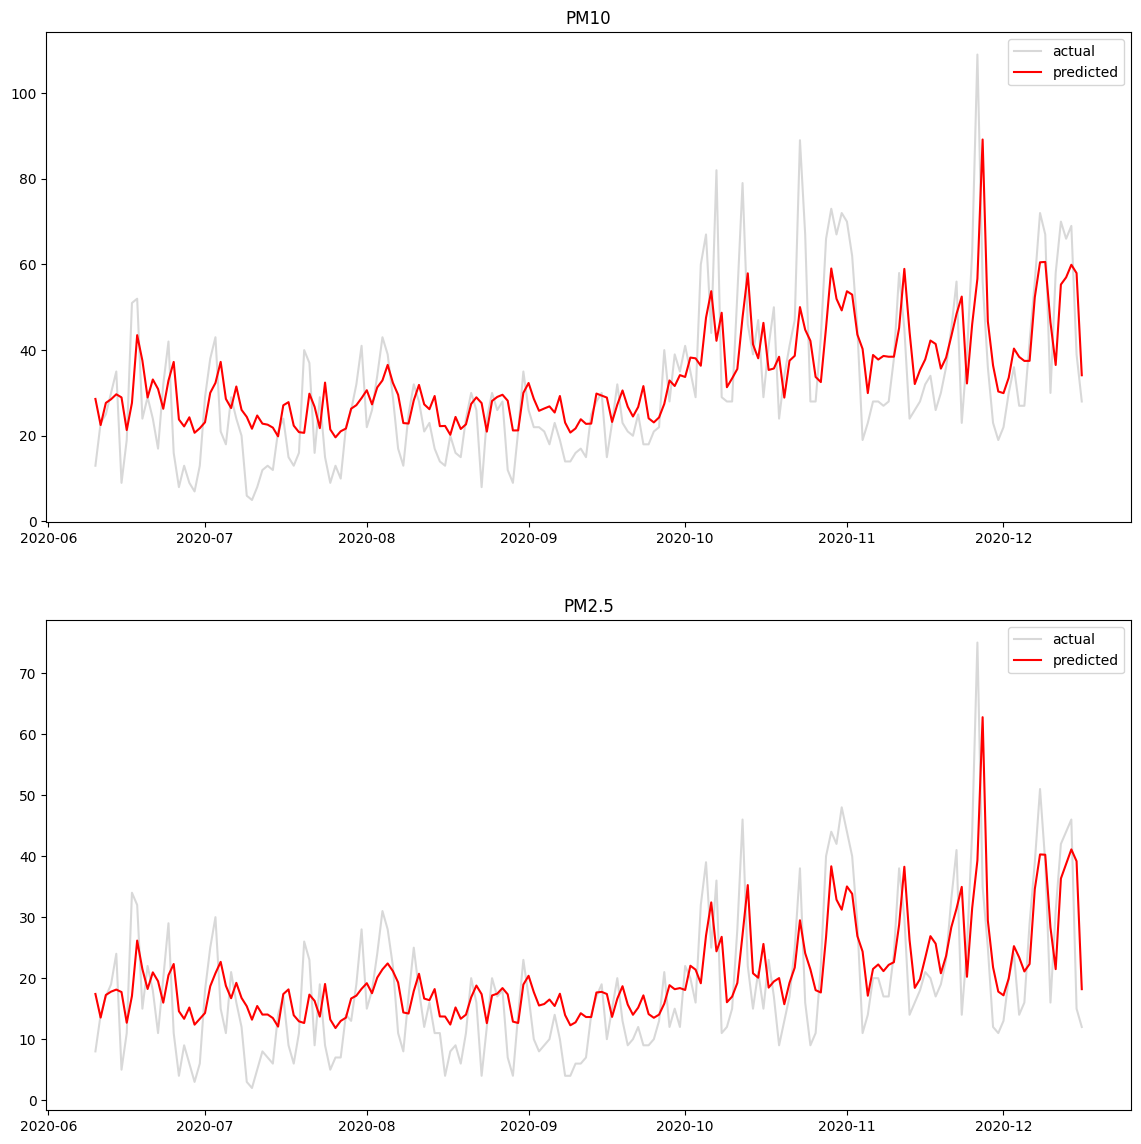

In [58]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# fit model
rf = RandomForestRegressor(n_estimators=2000, n_jobs=-1)
rf.fit(train_X, train_y)

# Evaluate score for the model
print('Train score: %.3f' % rf.score(train_X, train_y))
print('Test score: %.3f' % rf.score(test_X, test_y))

# make a one-step prediction
yhat = rf.predict(test_X)

pred = scaler2.inverse_transform(yhat)
actl = scaler2.inverse_transform(test_y)
mae = mean_absolute_error(actl, pred)
print('MAE: %.3f' % mae)
print('MSE: %.3f' % mean_squared_error(actl, pred))
print('RMSE: %.3f' % np.sqrt(mean_squared_error(actl, pred)))
print('MAPE: %.3f' % MAPE(actl, pred))

draw_plot(actl[:,0], pred[:,0], actl[:,1], pred[:,1])

### XGBoost for time series forecasting

In [59]:
from xgboost import XGBRegressor

# fit model
xg = XGBRegressor(objective='reg:squarederror', eval_metric='rmse', n_estimators=2000)
xg.fit(train_X, train_y[:,0])

# Evaluate score for the model
print('Train score: %.3f' % xg.score(train_X, train_y[:, 0]))
print('Test score: %.3f' % xg.score(test_X, test_y[:, 0]))

# make a one-step prediction
yhat = xg.predict(test_X)
yhat_r = np.append(yhat.reshape(yhat.shape[0], 1), np.zeros((yhat.shape[0], 1)), axis=1)

pred = scaler2.inverse_transform(yhat_r)
actl = scaler2.inverse_transform(test_y)

mae = mean_absolute_error(actl[:,0], pred[:,0])
print('MAE: %.3f' % mae)
print('MSE: %.3f' % mean_squared_error(actl[:,0], pred[:,0]))
print('RMSE: %.3f' % np.sqrt(mean_squared_error(actl[:,0], pred[:,0])))
print('MAPE: %.3f' % MAPE(actl, pred))

# fit model
xg2 = XGBRegressor(objective='reg:squarederror', eval_metric='rmse', n_estimators=2000)
xg2.fit(train_X, train_y[:,1])

# Evaluate score for the model
print('Train score: %.3f' % xg2.score(train_X, train_y[:, 1]))
print('Test score: %.3f' % xg2.score(test_X, test_y[:, 1]))

# make a one-step prediction
yhat = xg2.predict(test_X)
yhat_r = np.append(yhat.reshape(yhat.shape[0], 1), np.zeros((yhat.shape[0], 1)), axis=1)

pred2 = scaler2.inverse_transform(yhat_r)
actl2 = scaler2.inverse_transform(test_y)

mae = mean_absolute_error(actl2[:,0], pred2[:,0])
print('MAE: %.3f' % mae)
print('MSE: %.3f' % mean_squared_error(actl2[:,0], pred2[:,0]))
print('RMSE: %.3f' % np.sqrt(mean_squared_error(actl2[:,0], pred2[:,0])))
print('MAPE: %.3f' % MAPE(actl2, pred2))

Train score: 1.000
Test score: 0.450
MAE: 10.001
MSE: 175.179
RMSE: 13.236
MAPE: 64.740
Train score: 1.000
Test score: 0.427
MAE: 10.033
MSE: 188.565
RMSE: 13.732
MAPE: 62.218


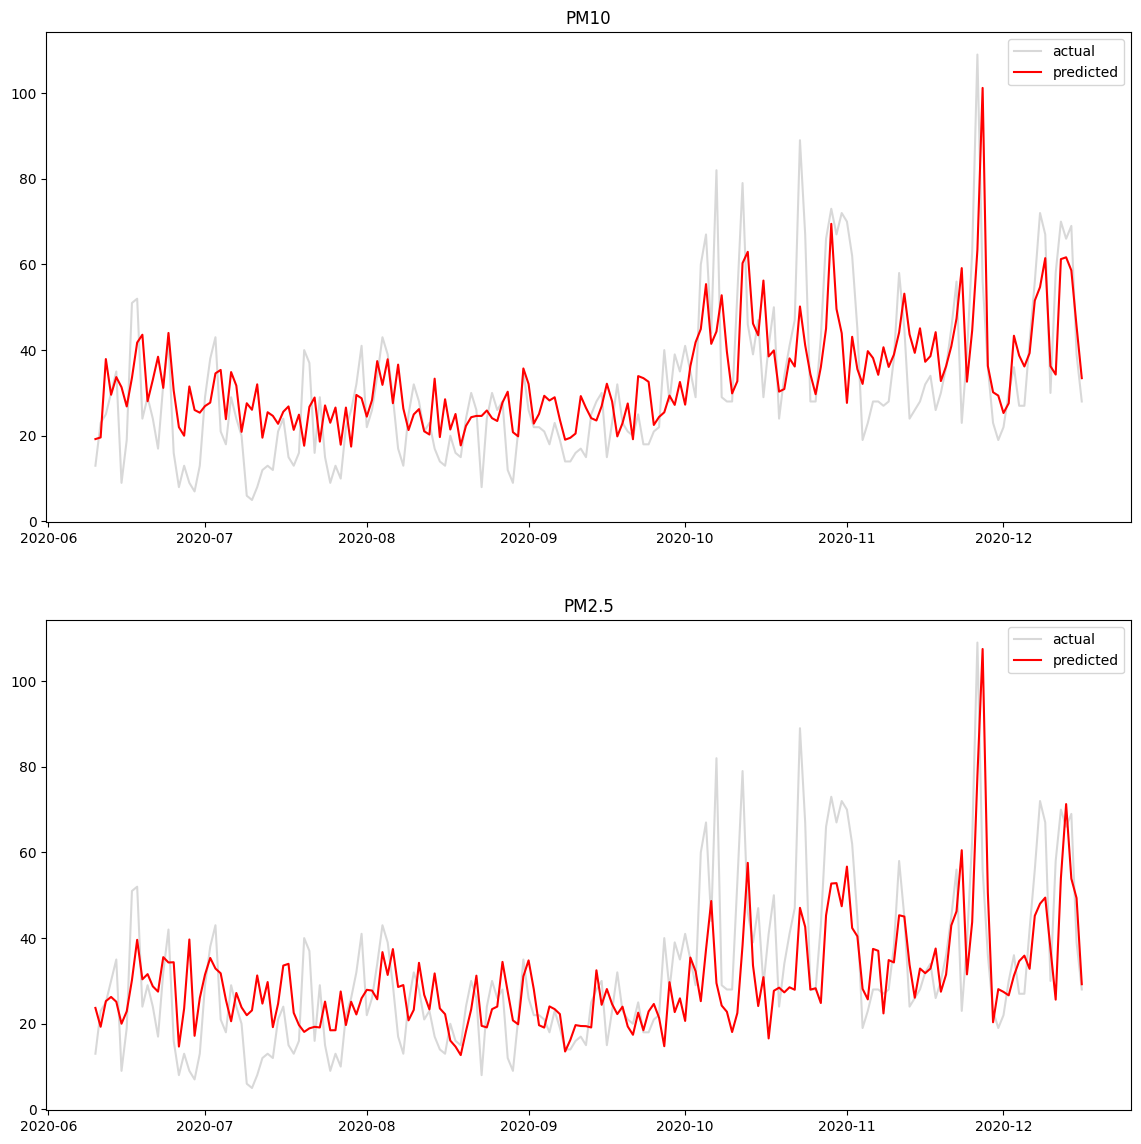

In [60]:
draw_plot(actl[:, 0], pred[:, 0], actl2[:, 0], pred2[:, 0])

### SVR for time series forecasting

In [61]:
from sklearn.svm import SVR

svr = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)
svr.fit(train_X, train_y[:,0])

# Evaluate score for the model
print('Train score: %.3f' % svr.score(train_X, train_y[:, 0]))
print('Test score: %.3f' % svr.score(test_X, test_y[:, 0]))

# make a one-step prediction
yhat = svr.predict(test_X)
yhat_r = np.append(yhat.reshape(yhat.shape[0], 1), np.zeros((yhat.shape[0], 1)), axis=1)

pred = scaler2.inverse_transform(yhat_r)
actl = scaler2.inverse_transform(test_y)

mae = mean_absolute_error(actl[:,0], pred[:,0])
print('MAE: %.3f' % mae)
print('MSE: %.3f' % mean_squared_error(actl[:,0], pred[:,0]))
print('RMSE: %.3f' % np.sqrt(mean_squared_error(actl[:,0], pred[:,0])))
print('MAPE: %.3f' % MAPE(actl, pred))

svr2 = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)
svr2.fit(train_X, train_y[:,1])

# Evaluate score for the model
print('Train score: %.3f' % svr2.score(train_X, train_y[:, 1]))
print('Test score: %.3f' % svr2.score(test_X, test_y[:, 1]))

# make a one-step prediction
yhat = svr2.predict(test_X)
yhat_r = np.append(yhat.reshape(yhat.shape[0], 1), np.zeros((yhat.shape[0], 1)), axis=1)

pred2 = scaler2.inverse_transform(yhat_r)
actl2 = scaler2.inverse_transform(test_y)

mae = mean_absolute_error(actl2[:,0], pred2[:,0])
print('MAE: %.3f' % mae)
print('MSE: %.3f' % mean_squared_error(actl2[:,0], pred2[:,0]))
print('RMSE: %.3f' % np.sqrt(mean_squared_error(actl2[:,0], pred2[:,0])))
print('MAPE: %.3f' % MAPE(actl2, pred2))

Train score: 0.694
Test score: -0.172
MAE: 16.448
MSE: 373.658
RMSE: 19.330
MAPE: 83.189
Train score: 0.683
Test score: 0.073
MAE: 12.826
MSE: 257.306
RMSE: 16.041
MAPE: 71.197


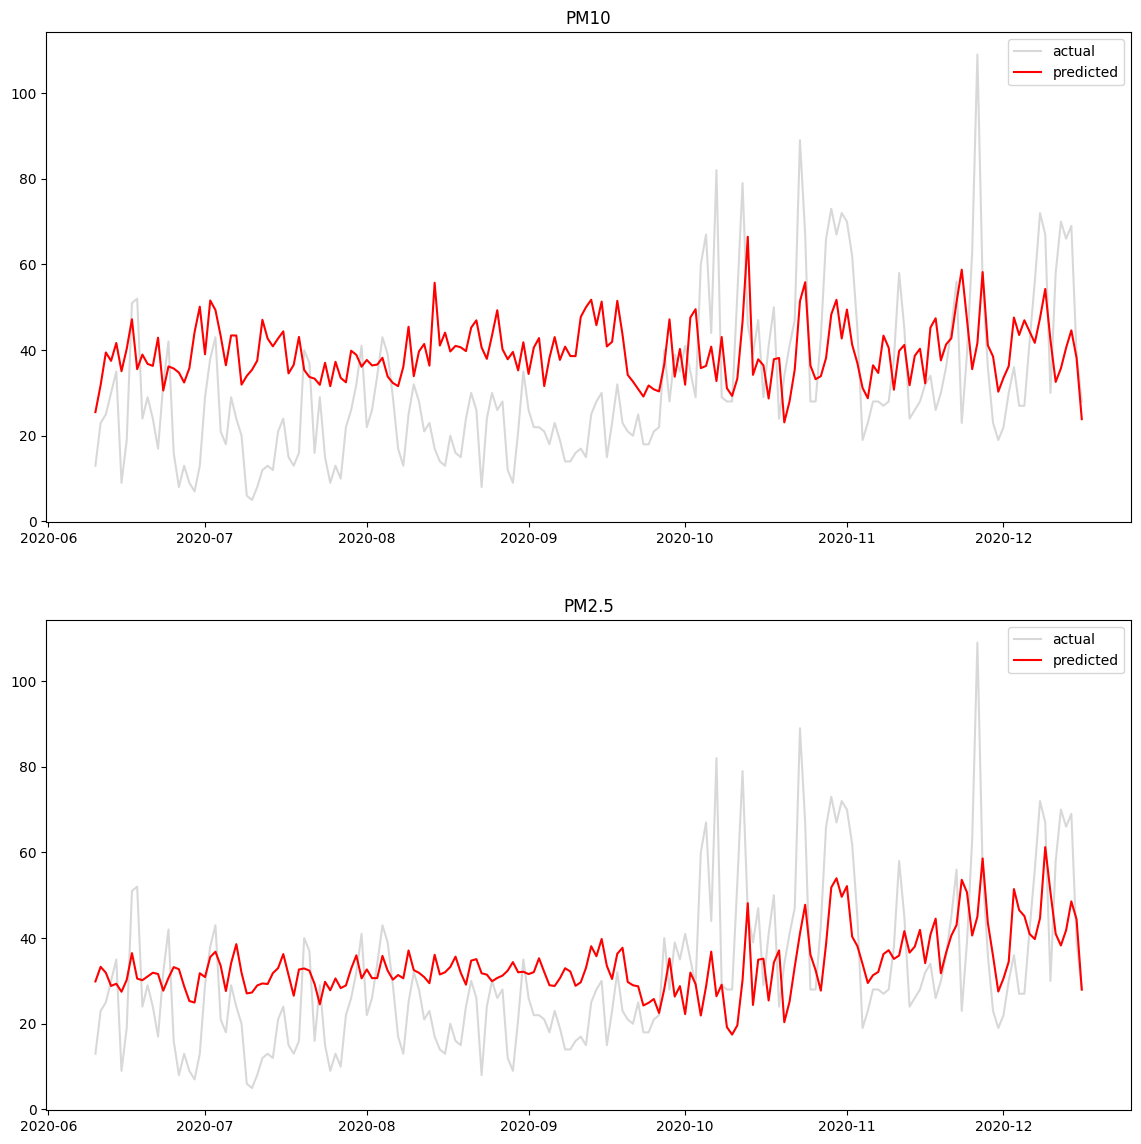

In [62]:
draw_plot(actl[:, 0], pred[:, 0], actl2[:, 0], pred2[:, 0])

### LSTM for time series forecasting

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Dropout
import tensorflow as tf

# For LSTM, the data should be 3d-array
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_in, n_features))
test_X = test_X.reshape((test_X.shape[0], n_in, n_features))

model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(2))
model.compile(loss='mse', optimizer='adam')
model.summary()

/Users/heavenly/opt/anaconda3/envs/mqed/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,098 (78.51 KB)

 Trainable params: 20,098 (78.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0251 - val_loss: 0.0102
Epoch 2/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0112 - val_loss: 0.0106
Epoch 3/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0142 - val_loss: 0.0099
Epoch 4/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0127 - val_loss: 0.0068
Epoch 5/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0118 - val_loss: 0.0075
Epoch 6/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0177 - val_loss: 0.0074
Epoch 7/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0119 - val_loss: 0.0073
Epoch 8/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0104 - val_loss: 0.0067
Epoch 9/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0094 - val_loss: 0.0062
Epoch 10/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0101 - val_loss: 0.0063
Epoch 11/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0101 - val_loss: 0.0064
Epoch 12/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0

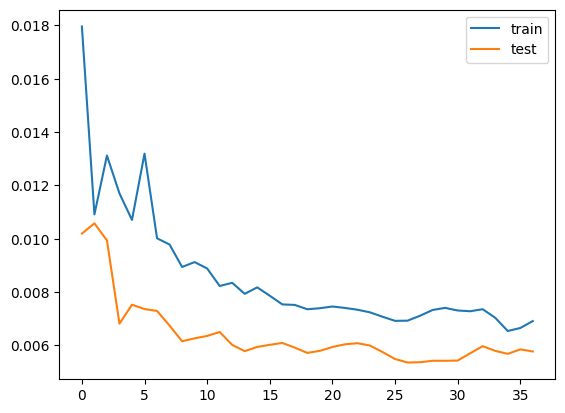

In [20]:
# Early Stopping
early_stoppings = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')

# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=50, validation_data=(test_X, test_y), 
                    verbose=1, shuffle=False, callbacks=early_stoppings)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
MAE: 8.149
MSE: 130.032
RMSE: 11.403
MAPE: 39.005


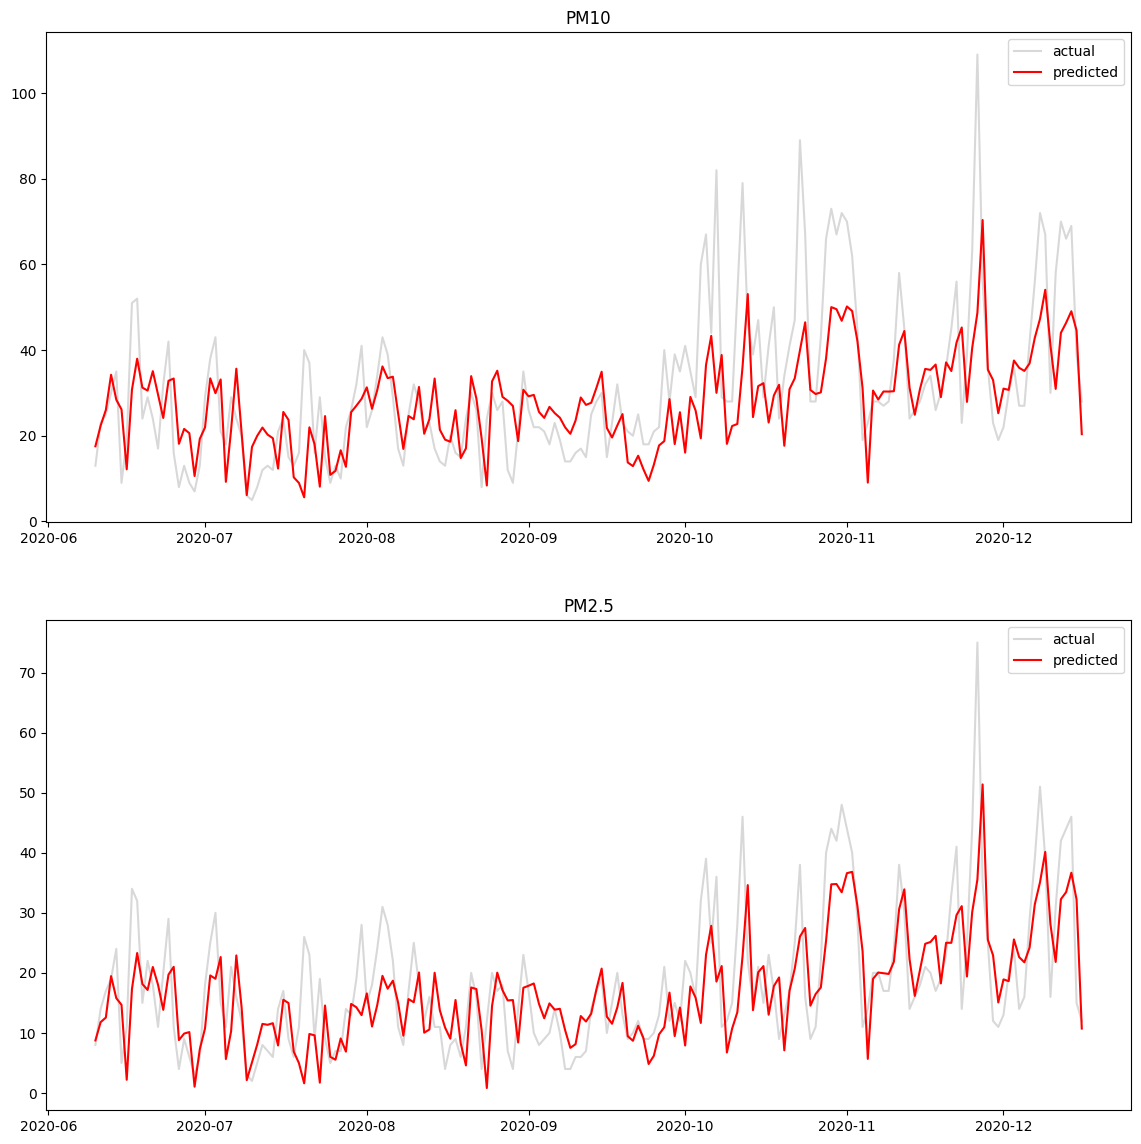

In [21]:
# make a prediction
yhat = model.predict(test_X)

pred = scaler2.inverse_transform(yhat)
actl = scaler2.inverse_transform(test_y)
mae = mean_absolute_error(actl, pred)
print('MAE: %.3f' % mae)
print('MSE: %.3f' % mean_squared_error(actl, pred))
print('RMSE: %.3f' % np.sqrt(mean_squared_error(actl, pred)))
print('MAPE: %.3f' % MAPE(actl, pred))

draw_plot(actl[:, 0], pred[:, 0], actl[:, 1], pred[:, 1])

## 여러 가지 데이터를 활용한 정확도의 차이 분석

In [22]:
from sklearn.preprocessing import MinMaxScaler

# 기상 정보만 활용하는 경우
df2 = df[['temp', 'prec', 'wind_spd', 'wind_sum', 'wind_dir', 'pascal', 'pm10', 'pm25']]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df2.values)
scaler2 = MinMaxScaler(feature_range=(0, 1))
scaler2.fit(df2[['pm10', 'pm25']])

n_in = 15 # 과거 15일을 통해 예측
n_out = 1
n_features = df2.shape[1]

reframed = series_to_supervised(scaled, n_in, 1)
values = reframed.values

n_train_hours = round(df.shape[0] * 0.8)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-n_features], train[:, -2:]
test_X, test_y = test[:, :-n_features], test[:, -2:]

### Random Forest

Train score: 0.934
Test score: 0.538
MAE: 7.790
MSE: 103.437
RMSE: 10.170
MAPE: 44.474


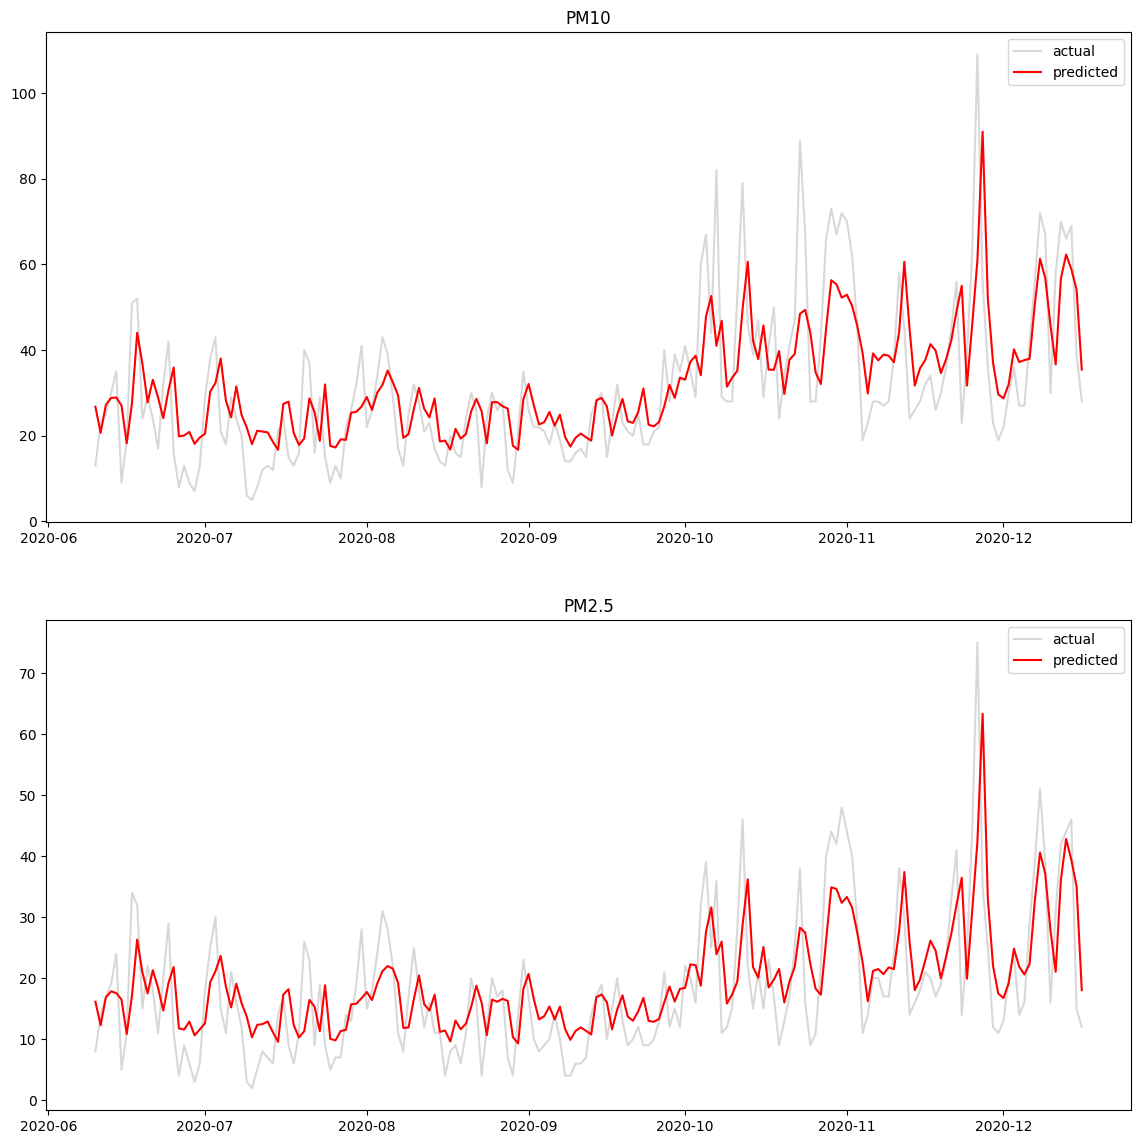

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# fit model
rf = RandomForestRegressor(n_estimators=2000, n_jobs=-1)
rf.fit(train_X, train_y)

# Evaluate score for the model
print('Train score: %.3f' % rf.score(train_X, train_y))
print('Test score: %.3f' % rf.score(test_X, test_y))

# make a one-step prediction
yhat = rf.predict(test_X)

pred = scaler2.inverse_transform(yhat)
actl = scaler2.inverse_transform(test_y)
mae = mean_absolute_error(actl, pred)
print('MAE: %.3f' % mae)
print('MSE: %.3f' % mean_squared_error(actl, pred))
print('RMSE: %.3f' % np.sqrt(mean_squared_error(actl, pred)))
print('MAPE: %.3f' % MAPE(actl, pred))

draw_plot(actl[:,0], pred[:,0], actl[:,1], pred[:,1])

### XGBoost

In [24]:
from xgboost import XGBRegressor

# fit model
xg = XGBRegressor(objective='reg:squarederror', eval_metric='rmse', n_estimators=2000)
xg.fit(train_X, train_y[:,0])

# Evaluate score for the model
print('Train score: %.3f' % xg.score(train_X, train_y[:, 0]))
print('Test score: %.3f' % xg.score(test_X, test_y[:, 0]))

# make a one-step prediction
yhat = xg.predict(test_X)
yhat_r = np.append(yhat.reshape(yhat.shape[0], 1), np.zeros((yhat.shape[0], 1)), axis=1)

pred = scaler2.inverse_transform(yhat_r)
actl = scaler2.inverse_transform(test_y)

mae = mean_absolute_error(actl[:,0], pred[:,0])
print('MAE: %.3f' % mae)
print('MSE: %.3f' % mean_squared_error(actl[:,0], pred[:,0]))
print('RMSE: %.3f' % np.sqrt(mean_squared_error(actl[:,0], pred[:,0])))
print('MAPE: %.3f' % MAPE(actl, pred))

# fit model
xg2 = XGBRegressor(objective='reg:squarederror', eval_metric='rmse', n_estimators=2000)
xg2.fit(train_X, train_y[:,1])

# Evaluate score for the model
print('Train score: %.3f' % xg2.score(train_X, train_y[:, 1]))
print('Test score: %.3f' % xg2.score(test_X, test_y[:, 1]))

# make a one-step prediction
yhat = xg2.predict(test_X)
yhat_r = np.append(yhat.reshape(yhat.shape[0], 1), np.zeros((yhat.shape[0], 1)), axis=1)

pred2 = scaler2.inverse_transform(yhat_r)
actl2 = scaler2.inverse_transform(test_y)

mae = mean_absolute_error(actl2[:,0], pred2[:,0])
print('MAE: %.3f' % mae)
print('MSE: %.3f' % mean_squared_error(actl2[:,0], pred2[:,0]))
print('RMSE: %.3f' % np.sqrt(mean_squared_error(actl2[:,0], pred2[:,0])))
print('MAPE: %.3f' % MAPE(actl2, pred2))

Train score: 1.000
Test score: 0.419
MAE: 10.494
MSE: 185.319
RMSE: 13.613
MAPE: 63.040
Train score: 1.000
Test score: 0.477
MAE: 9.649
MSE: 180.062
RMSE: 13.419
MAPE: 60.308


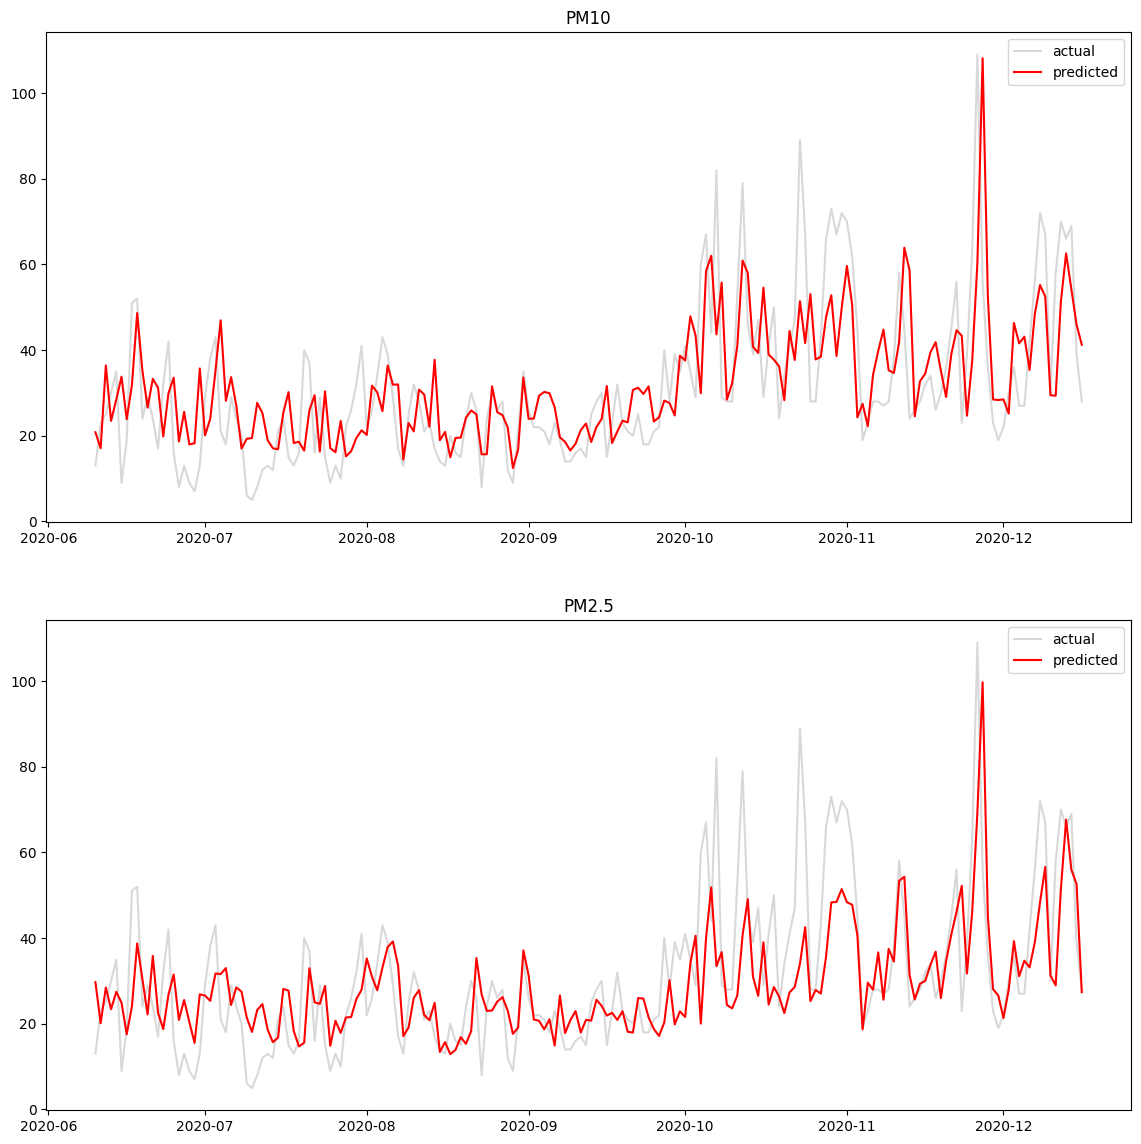

In [25]:
draw_plot(actl[:, 0], pred[:, 0], actl2[:, 0], pred2[:, 0])

### SVR

In [26]:
from sklearn.svm import SVR

svr = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)
svr.fit(train_X, train_y[:,0])

# Evaluate score for the model
print('Train score: %.3f' % svr.score(train_X, train_y[:, 0]))
print('Test score: %.3f' % svr.score(test_X, test_y[:, 0]))

# make a one-step prediction
yhat = svr.predict(test_X)
yhat_r = np.append(yhat.reshape(yhat.shape[0], 1), np.zeros((yhat.shape[0], 1)), axis=1)

pred = scaler2.inverse_transform(yhat_r)
actl = scaler2.inverse_transform(test_y)

mae = mean_absolute_error(actl[:,0], pred[:,0])
print('MAE: %.3f' % mae)
print('MSE: %.3f' % mean_squared_error(actl[:,0], pred[:,0]))
print('RMSE: %.3f' % np.sqrt(mean_squared_error(actl[:,0], pred[:,0])))
print('MAPE: %.3f' % MAPE(actl, pred))

svr2 = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)
svr2.fit(train_X, train_y[:,1])

# Evaluate score for the model
print('Train score: %.3f' % svr2.score(train_X, train_y[:, 1]))
print('Test score: %.3f' % svr2.score(test_X, test_y[:, 1]))

# make a one-step prediction
yhat = svr2.predict(test_X)
yhat_r = np.append(yhat.reshape(yhat.shape[0], 1), np.zeros((yhat.shape[0], 1)), axis=1)

pred2 = scaler2.inverse_transform(yhat_r)
actl2 = scaler2.inverse_transform(test_y)

mae = mean_absolute_error(actl2[:,0], pred2[:,0])
print('MAE: %.3f' % mae)
print('MSE: %.3f' % mean_squared_error(actl2[:,0], pred2[:,0]))
print('RMSE: %.3f' % np.sqrt(mean_squared_error(actl2[:,0], pred2[:,0])))
print('MAPE: %.3f' % MAPE(actl2, pred2))

Train score: 0.701
Test score: 0.191
MAE: 13.100
MSE: 257.721
RMSE: 16.054
MAPE: 71.384
Train score: 0.692
Test score: 0.303
MAE: 11.158
MSE: 229.325
RMSE: 15.143
MAPE: 62.916


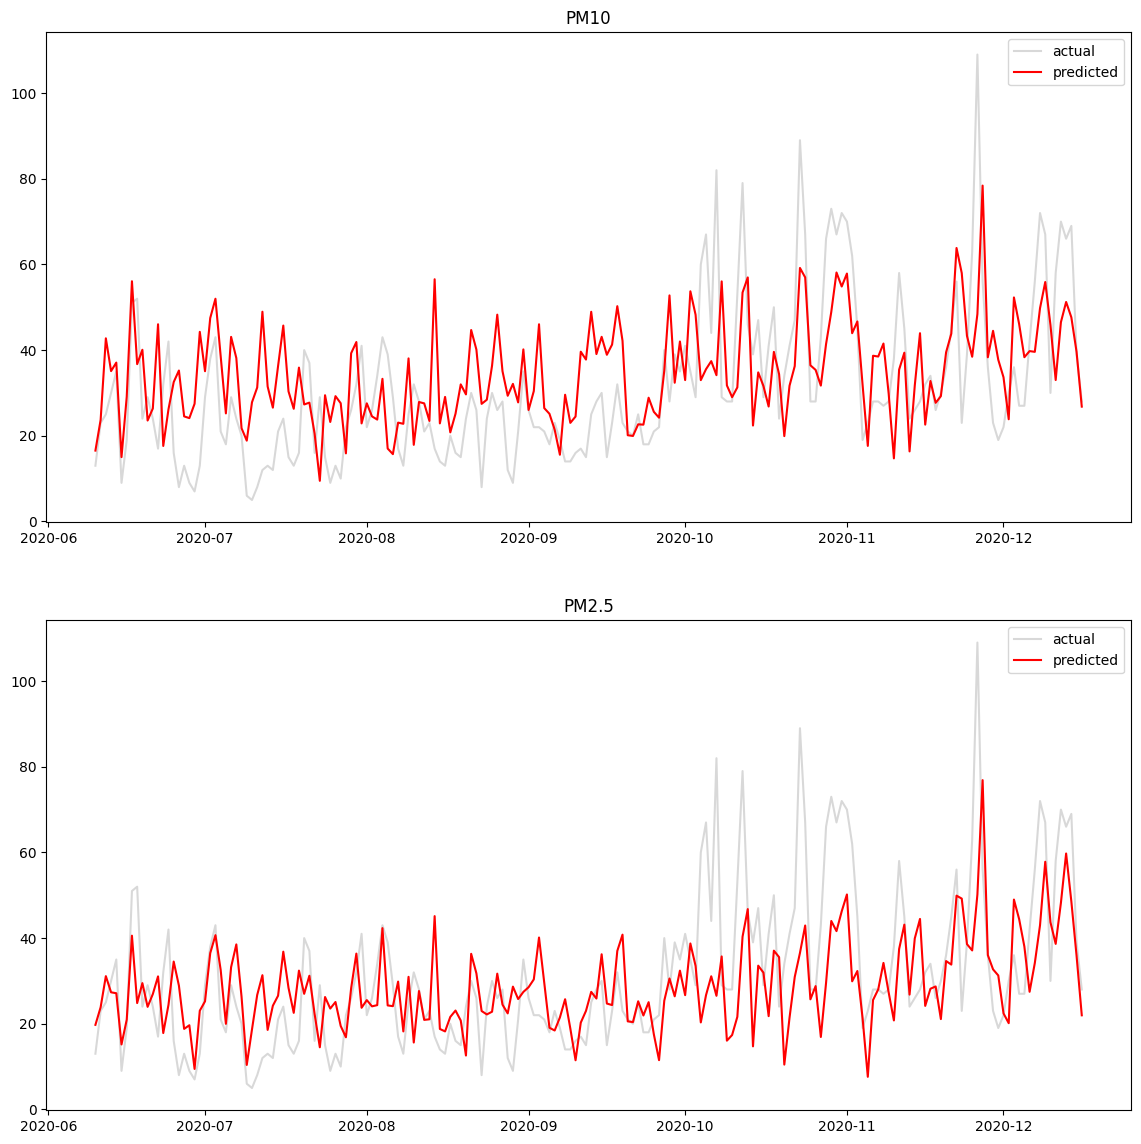

In [27]:
draw_plot(actl[:, 0], pred[:, 0], actl2[:, 0], pred2[:, 0])

### LSTM

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Dropout
import tensorflow as tf

# For LSTM, the data should be 3d-array
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_in, n_features))
test_X = test_X.reshape((test_X.shape[0], n_in, n_features))

model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(2))
model.compile(loss='mse', optimizer='adam')
model.summary()

/Users/heavenly/opt/anaconda3/envs/mqed/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,818 (73.51 KB)

 Trainable params: 18,818 (73.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0511 - val_loss: 0.0127
Epoch 2/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0187 - val_loss: 0.0128
Epoch 3/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0145 - val_loss: 0.0093
Epoch 4/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0130 - val_loss: 0.0084
Epoch 5/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0116 - val_loss: 0.0077
Epoch 6/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0109 - val_loss: 0.0075
Epoch 7/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105 - val_loss: 0.0075
Epoch 8/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0102 - val_loss: 0.0075
Epoch 9/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100 - val_loss: 0.0075
Epoch 10/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0100 - val_loss: 0.0076
Epoch 11/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100 - val_loss: 0.0076
Epoch 12/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0

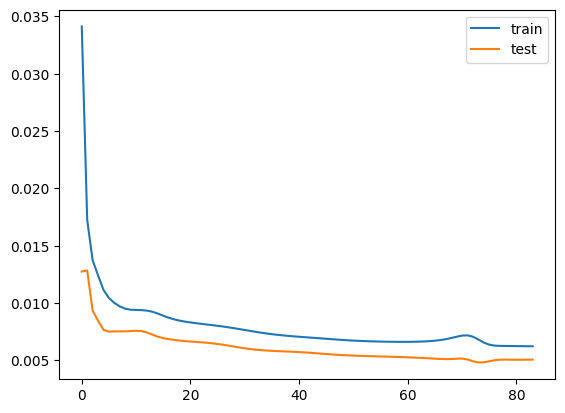

In [29]:
# Early Stopping
early_stoppings = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')

# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size= 50, validation_data=(test_X, test_y), 
                    verbose=1, shuffle=False, callbacks=early_stoppings)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
MAE: 7.695
MSE: 111.975
RMSE: 10.582
MAPE: 39.519


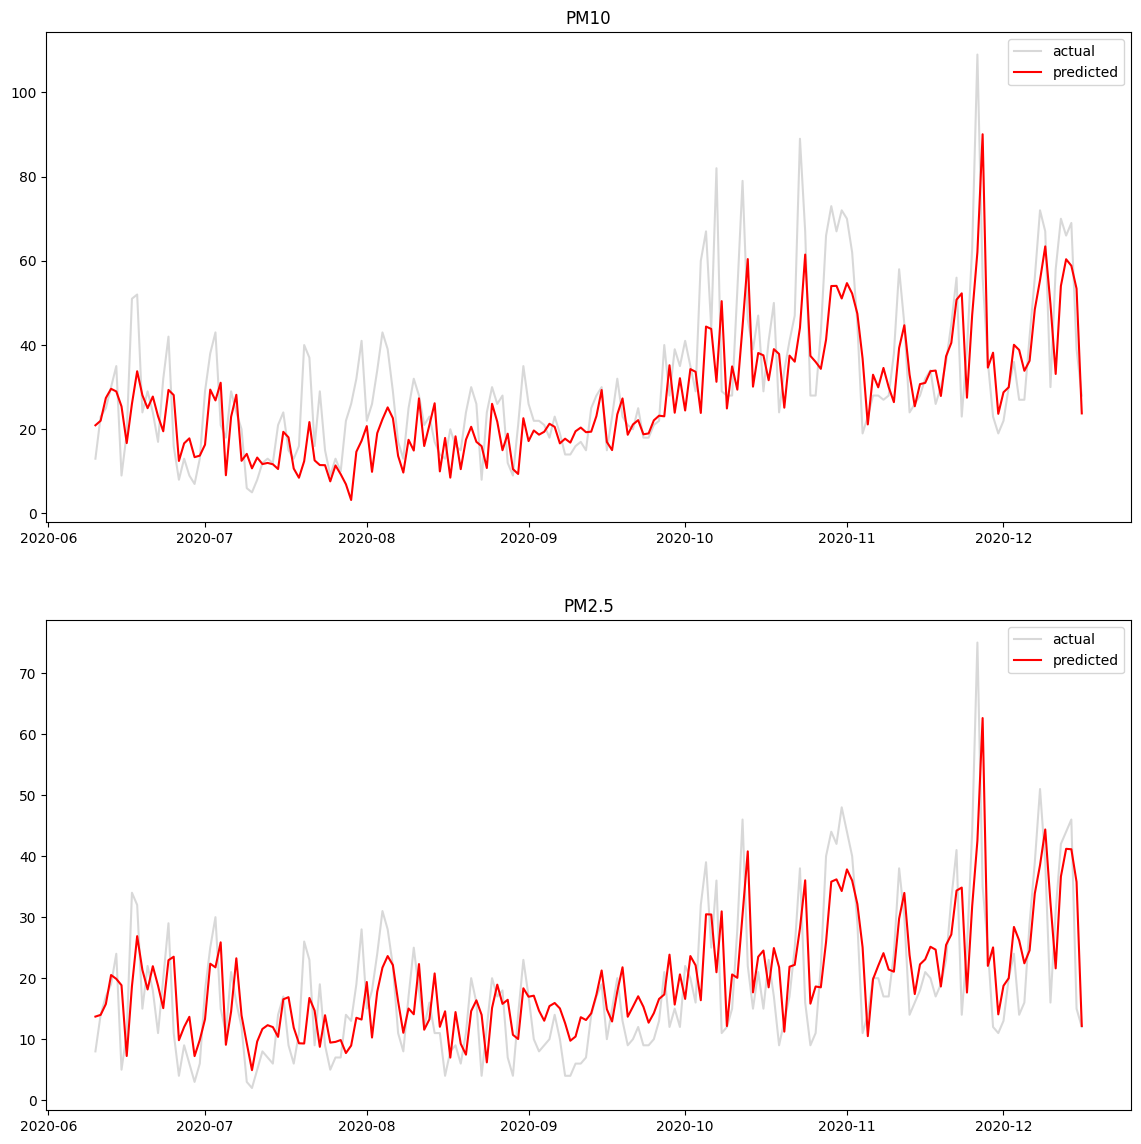

In [30]:
# make a prediction
yhat = model.predict(test_X)

pred = scaler2.inverse_transform(yhat)
actl = scaler2.inverse_transform(test_y)
mae = mean_absolute_error(actl, pred)
print('MAE: %.3f' % mae)
print('MSE: %.3f' % mean_squared_error(actl, pred))
print('RMSE: %.3f' % np.sqrt(mean_squared_error(actl, pred)))
print('MAPE: %.3f' % MAPE(actl, pred))

draw_plot(actl[:, 0], pred[:, 0], actl[:, 1], pred[:, 1])